Plano de hoje
-------------

1. Ambiente de programação
2. Usando o computador para calcular    
3. Usando o computador para desenhar
4. Usando o computador para integrar: quadraturas
5. Usando o computador para aproximar: interpolação
    1. Interpolação local
    2. Interpolação de Lagrange

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Interpolação e extrapolação

A principal razão para interpolar uma função é que esta pode ser "desconhecida".
Isso pode se apresentar em vários níveis:

1. A função que queremos representar só pode ser conhecida experimentalmente
    - Pressão do ar a uma certa altitude (p em função de h)
    - Concentração de sódio na água do mar (c em função de $x,y,z$)
    - Cotação do dólar (\$ em função de t)
    - ...
2. A função talvez tenha uma definição, mas esta pode ser muito complicada de obter
    - "Problemas inversos": $f(x) = y$ onde $x^2 y + exp(y/x) = 39$
    - "Problemas aritméticos": $f(x) = \text{soma dos divisores de $x$}$.
    - ...
3. Uma combinação dos fenômenos acima

Assim, uma vez que tenhamos dados "suficientes", vamos querer usá-los para ter uma idéia do comportamento global de $f$.
Por exemplo, imagine que saibamos que:

    x    = 0 1 2 5 10
    f(x) = 2 3 3 5 7
Será que podemos prever como será $f(4)$? Isso é o que chamamos de um problema de **interpolação**.
Será que podemos prever como será $f(12)$? Isso é um problema de **extrapolação**.

(0, 10)

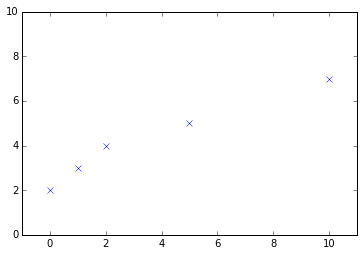

In [2]:
x = [0,1,2,5,10]
y = [2,3,4,5,7]
plot(x,y, 'x')
xlim([-1,11])
ylim([0,10])

# Interpolação local

A solução **mais simples**, mas muitas vezes suficiente, é, simplesmente, "ligar os pontos com retas".
Se você pensar, o plot faz _exatamente_ isso!

(0, 10)

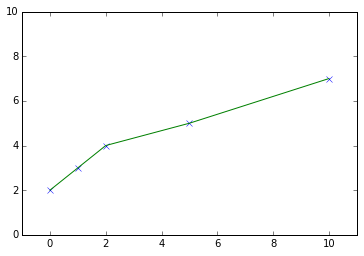

In [3]:
plot(x,y, 'x')
plot(x,y)
xlim([-1,11])
ylim([0,10])

Este método tem um nome pomposo, se você quiser parecer erudito: _interpolação linear por partes_.
Vejamos porquê:

1. _interpolação_, porque calcula valores "razoáveis" (num certo sentido) para a função apenas "dentro" do intervalo de seus pontos conhecidos
2. _linear_, porque usa uma reta (linha!) para obter os tais valores
3. _por partes_, porque usa uma reta diferente em cada intervalo.

Lembrando dos nossos métodos integrais, podemos renomeá-los!

### Exercício:
Em que categoria se enquadram os métodos de Cauchy, do ponto médio, trapezoidal?
E os dois métodos de ordem 4 (Simpson e Gauss-Legendre)?

## Aumentando a ordem de interpolação

Ao contrário dos métodos que usamos para integrais, e como já vimos no exemplo, nem sempre possuímos pontos igualmente espaçados onde vamos interpolar.
Mas isso não nos impedirá de interpolar a função, apenas teremos que tomar "mais pontos".

### Exercício

Interpole por polinômios de grau 2 os dados acima.

Vemos, assim, que usar interpoladores de maior grau pode ser melhor
(quem sabe capturamos melhor o comportamento da função)
mas traz também o problema de **qual** interpolante escolher para um mesmo intervalo.

Voltaremos a este problema com splines, mais à frente.

# Interpolação global

Uma outra idéia é usar **todas** informações simultaneamente.
Assim, podemos usar uma parte para corrigir outra.

## O polinômio interpolador de Lagrange

A idéia fundamental do PIL é que, dados $n+1$ pontos conhecidos,
existe apenas um polinômio de grau $n$ que passa por eles.
Este será o "melhor" polinômio de grau menor ou igual a $n$ que interpola estes dados,
e não faz muito sentido tentar achar polinômios de mais alto grau,
porque existem infinitos que vão passar pelos mesmos pontos!

Assim, temos que descobrir $n+1$ coeficientes - digamos $a_0, a_1, \ldots, a_n$ -
para o nosso polinômio, em função de $n+1$ pontos $x$ e $y$.

### Exercício:
Monte o sistema das $n+1$ equações, e ache uma matriz de Vandermonde!

In [4]:
def lagrange(x,y):
    """ Calcula o polinômio interpolador de Lagrange dos pontos $(x_i, y_i)$. """
    assert(len(x) == len(y))
    n = len(x) - 1
    maxx = max(x)
    minx = min(x)
    medx = (maxx + minx)/2
    diffs = array(x) - medx
    M = [ones_like(x)]
    for i in range(n):
        M.append(M[-1]*diffs)
    M = array(M).T
    a = solve(M,y)
    
    def p(z):
        return Horner(z - medx,a[::-1])
    return p

In [5]:
def Horner(x, rcoeff):
    # Inicialização
    acc = rcoeff[0]
    for c in rcoeff[1:]:
        acc *= x
        acc += c
    return acc

In [6]:
p_i_l = lagrange(x,y)

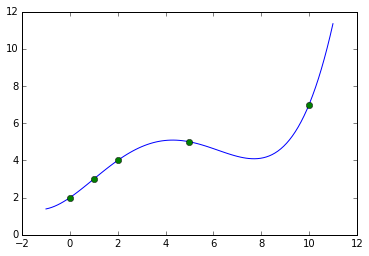

In [7]:
t = linspace(-1,11,100)
plot(t,p_i_l(t))
plot(x,y,'o')

O que vemos aqui é um fenômeno estranho:
apesar de os dados serem crescentes, o interpolador não é crescente!

Este é um dos problemas que atingem a interpolação de Lagrange.
Veremos porquê.

## Análise da interpolação de Lagrange

Apesar de termos formulado o problema de interpolação de Lagrange como a solução de um sistema linear,
é possível expressar a solução de outras formas.

### Polinômios especiais

Como estamos trabalhando com polinômios de grau 4 (porque temos 5 pontos),
o maior número de zeros que um tal polinômio pode ter é 4.
Aliás, é exatamente isso que garante que a solução é _única_.

Vejamos que, dados 5 pontos, existem polinômios de grau 4 que sejam "mais especiais" do que outros.
Especial também pode ser "simples", e por isso vamos tentar achar polinômios "mais simples".
Uma idéia nessa direção é a seguinte: para cada um dos pontos $x_i$,
existe um único polinômio $P_i$ que vale $1$ neste ponto, e $0$ nos outros 4.
Como ele vale zero em 4 pontos e tem grau 4, ele tem que ser da forma
$$ P_i(x) = C_i \prod_{j \neq i} (x - x_j), $$
onde $C_i$ é uma constante.
Ora, se $P_i(x_i) = 1$, isso dá uma equação para $C_i$:
$$ 1 = C_i \prod_{j \neq i} (x_i - x_j). $$
Assim, temos:
$$ P_i = \prod_{j \neq i} \frac{x - x_j}{x_i - x_j}.$$

Agora, note que se uma função $f$ vale $y_0 \neq 0$ em $x_0$
a _única_ forma de, usando os $P_i$, obter este valor será usando $y_0 \times P_i(x)$.

### Exercício

Deduza a fórmula do polinômio interpolador de Lagrange de $f$ nos $x_i$:
$$ I_f(x) = \sum_{i = 0}^n \left[ y_i \prod_{j \neq i} \frac{x - x_j}{x_i - x_j} \right]. $$
Plote os 5 polinômios $P_i$ para os pontos $x = [0,1,2,5,10]$.